# Parameter tuning

This script is to tune the parameters of a model and test different parameters.

To test different models and types (BERT, GPT2, XLNet, ...) it can be changed in the MultiLabelClassificationModel function as descibed in the [Simple transformers docs](https://simpletransformers.ai/docs/installation/). 

### SDG classifier

In [1]:
# define imports
import wandb
import torch
import sklearn
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel, MultiLabelClassificationArgs

In [2]:
# see GPU avaialability
cuda_available = torch.cuda.is_available()

% PER CLASS:

 SDG1      5.354267
SDG2      5.152979
SDG3      7.447665
SDG4      4.388084
SDG5      4.186795
SDG6      5.314010
SDG7      5.756844
SDG8      6.400966
SDG9      5.636071
SDG10     5.152979
SDG11     5.354267
SDG12     5.112721
SDG13    10.265700
SDG14     4.830918
SDG15     5.676329
SDG16     4.951691
SDG17     9.017713
dtype: float64


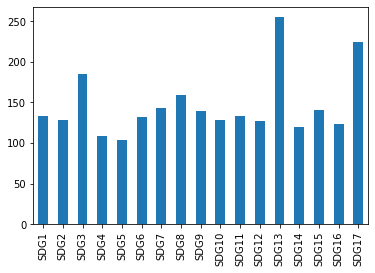

In [3]:
# import data
data = pd.read_csv('OneHot_Combined_cln_utf8.tsv', sep='\t')
data = data.iloc[-1000:,:] # only use a subset of the data 

# reformat data
sdg_lst = ['SDG1','SDG2','SDG3','SDG4','SDG5','SDG6','SDG7','SDG8','SDG9','SDG10','SDG11','SDG12','SDG13','SDG14','SDG15','SDG16','SDG17']
data['y'] = data[sdg_lst].values.tolist()
y = data['y']
X = data['abstract']

# plot ratio of data
class_weight = (data[sdg_lst].sum()/ data[sdg_lst].sum().sum())
print('% PER CLASS:\n\n', class_weight*100)
data[sdg_lst].sum().plot.bar()

# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# add data to dataframes
train_df = pd.DataFrame()
train_df['text'] = X_train
train_df['labels'] = y_train
train_df.reset_index(inplace=True, drop=True)
eval_df = pd.DataFrame()
eval_df['text'] = X_val
eval_df['labels'] = y_val
eval_df.reset_index(inplace=True, drop=True)

# get number of classes
label_count = len(sdg_lst)

In [4]:
# create functions for additional evaluation outputs
def acc_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    acc = sklearn.metrics.accuracy_score(true, pred)
    return acc

def f1_macro_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    f1 = sklearn.metrics.f1_score(true, pred, average='macro')
    return f1

def f1_micro_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    f1 = sklearn.metrics.f1_score(true, pred, average='micro')
    return f1

def cm_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    cm = wandb.plot.confusion_matrix(probs=None, y_true=true, preds=pred, class_names=sdg_lst) #sklearn.metrics.multilabel_confusion_matrix(true, pred)
    return cm

# create function for creating layer learning rate dictionary
# this is used for freezing the number of layers from the first layer -> x layer
def create_custom_layer_dict_lst(x):    
    # get list of number of layers
    # layers_lst = [0]
    # for i in model.get_named_parameters():
    #     layers_lst.append(int(re.findall(r"layer\.(\d+)", i)[0]))
    #     layers_lst = list(set(layers_lst))
    # create dictionary of 
    layer_dict_lst = []
    for i in range(x+1):
        layer_dict_lst.append({'layer':i, 'lr':0.0})
    return layer_dict_lst

In [5]:
# Define the sweep config. 
# this defines the parameters that will be searched when performing parameter optimisation
sweep_config = {
    "method": "bayes",  # bayes, grid, random
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 1, "max": 5},
        "learning_rate": {"min": 5e-5, "max": 4e-4},
        "train_batch_size":{"min": 1, "max": 30},
        "eval_batch_size":{"min": 1, "max": 30},
        "warmup_steps":{"min": 50, "max": 500},
        "weight_decay":{"min": 0.01, "max": 0.1},
        # "logging_steps":{"min": 1, "max": 20}, #{"values": [2, 5, 10]}
        "threshold":{"min":0.0, "max":1.0},
        'custom_layer_parameters':{"values": [create_custom_layer_dict_lst(0), create_custom_layer_dict_lst(6), create_custom_layer_dict_lst(8)]}
    },
}

# define the project and entity under which the outputs will be recorded in wandb
sweep_id = wandb.sweep(sweep_config, entity='sasdghub', project="sasdghub_ml_classify")

# Set logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

Create sweep with ID: bamks942
Sweep URL: https://wandb.ai/sasdghub/sasdghub_ml_classify/sweeps/bamks942


In [ ]:
# Optional model configuration
model_args = MultiLabelClassificationArgs(fp16= False,
                                          manual_seed = 4,
                                          use_multiprocessing = True,
                                          overwrite_output_dir=True,
                                          evaluate_during_training = True,
                                          # save_model_every_epoch = False, 
                                          # save_steps=-1, # use this parameter and the next parameter to train on text of longer than 512 words in length
                                          # sliding_window=True, # these parameters are bugged in this current version and will likely be updated soon
                                         )

# define the training function
def train():
    
    # Initialize a new wandb run 
    wandb.init()

    # Create a MultiLabelClassificationModel
    model = MultiLabelClassificationModel(
        "xlnet",
        "xlnet-base-cased",
        num_labels=label_count,
        args=model_args,
        use_cuda=cuda_available,
        pos_weight=list((1/label_count)/class_weight),
        # show_running_loss=True,
        sweep_config=wandb.config,
    )
        
    # Train the model
    model.train_model(train_df,
                      verbose=True,
                      eval_df=eval_df,
                      accuracy=acc_result,
                      f1_macro=f1_macro_result,
                      f1_micro=f1_micro_result,
                      cm=cm_result)
    
    # Evaluate the model
    result, model_outputs, wrong_predictions = model.eval_model(
        eval_df,
        verbose=True,
        accuracy=acc_result,
        f1_macro=f1_macro_result,
        f1_micro=f1_micro_result,
        cm=cm_result
    )
    
    # Sync wandb
    wandb.join()

# run the sweep and record results in wandb    
wandb.agent(sweep_id, train)

INFO:wandb.agents.pyagent:Starting sweep agent: entity=None, project=None, count=None
wandb: Agent Starting Run: kemz4z7r with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}]
wandb: 	eval_batch_size: 2
wandb: 	learning_rate: 7.165837495843036e-05
wandb: 	num_train_epochs: 2
wandb: 	threshold: 0.936601928390828
wandb: 	train_batch_size: 20
wandb: 	warmup_steps: 144
wandb: 	weight_decay: 0.041425057259294434
wandb: Currently logged in as: christopher-marais (sasdghub). Use `wandb login --relogin` to force relogin


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/700 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_0_2
C:\ProgramData\Anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 1 of 2:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2
INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'LRAP': 0.45783233552590624, 'accuracy': 0.18333333333333332, 'f1_macro': 0.0732348738758532, 'f1_micro': 0.18333333333333332, 'cm': <wandb.viz.CustomChart object at 0x0000025775752DC0>, 'eval_loss': 0.37654345045487086}


LRAP,▁█
Training loss,▁
accuracy,▁█
eval_loss,█▁
f1_macro,▁█
f1_micro,▁█
global_step,▁▄█
lr,▁
train_loss,▁█
LRAP,0.45783
Training loss,0.42606


wandb: Agent Starting Run: 5hng84kv with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}]
wandb: 	eval_batch_size: 26
wandb: 	learning_rate: 0.00017498396707509308
wandb: 	num_train_epochs: 1
wandb: 	threshold: 0.6045013098252412
wandb: 	train_batch_size: 17
wandb: 	warmup_steps: 367
wandb: 	weight_decay: 0.01260947992073472


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/700 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_0_2
C:\ProgramData\Anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/42 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2
INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'LRAP': 0.289414922538416, 'accuracy': 0.07, 'f1_macro': 0.01566525958006688, 'f1_micro': 0.07, 'cm': <wandb.viz.CustomChart object at 0x000002570A1C71C0>, 'eval_loss': 0.41864905258019763}


LRAP,▁
accuracy,▁
eval_loss,▁
f1_macro,▁
f1_micro,▁
global_step,▁
train_loss,▁
LRAP,0.28941
accuracy,0.07
eval_loss,0.41865
f1_macro,0.01567


wandb: Agent Starting Run: g2u74bkp with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}]
wandb: 	eval_batch_size: 15
wandb: 	learning_rate: 0.00027513023130930825
wandb: 	num_train_epochs: 4
wandb: 	threshold: 0.9774549111512584
wandb: 	train_batch_size: 25
wandb: 	warmup_steps: 427
wandb: 	weight_decay: 0.04315724627128794


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/700 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_0_2
C:\ProgramData\Anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 1 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 2 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 3 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2
INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Evaluation:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'LRAP': 0.8024048650284135, 'accuracy': 0.5133333333333333, 'f1_macro': 0.48420058937975474, 'f1_micro': 0.5133333333333333, 'cm': <wandb.viz.CustomChart object at 0x000002570BFDAC70>, 'eval_loss': 0.29360719919204714}


LRAP,▁▂▄█
Training loss,▁█
accuracy,▁▂▄█
eval_loss,█▆▄▁
f1_macro,▁▁▃█
f1_micro,▁▂▄█
global_step,▁▃▃▆▇█
lr,▁▁
train_loss,▆█▄▁
LRAP,0.8024
Training loss,0.42877


wandb: Agent Starting Run: 3asgpqxi with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}]
wandb: 	eval_batch_size: 10
wandb: 	learning_rate: 0.0003268990360770905
wandb: 	num_train_epochs: 2
wandb: 	threshold: 0.8503806031766953
wandb: 	train_batch_size: 18
wandb: 	warmup_steps: 224
wandb: 	weight_decay: 0.032668000759160376


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/700 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_0_2
C:\ProgramData\Anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/39 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 1 of 2:   0%|          | 0/39 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2
INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Evaluation:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'LRAP': 0.7159041061282028, 'accuracy': 0.45, 'f1_macro': 0.41250708085006194, 'f1_micro': 0.45, 'cm': <wandb.viz.CustomChart object at 0x000002570E12D580>, 'eval_loss': 0.3334989592432976}


LRAP,▁█
Training loss,▁
accuracy,▁█
eval_loss,█▁
f1_macro,▁█
f1_micro,▁█
global_step,▁▃█
lr,▁
train_loss,▁█
LRAP,0.7159
Training loss,0.3553


wandb: Agent Starting Run: 8ln869gn with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}, {'layer': 7, 'lr': 0}, {'layer': 8, 'lr': 0}]
wandb: 	eval_batch_size: 13
wandb: 	learning_rate: 0.00020700944880740996
wandb: 	num_train_epochs: 5
wandb: 	threshold: 0.8337220757814678
wandb: 	train_batch_size: 24
wandb: 	warmup_steps: 423
wandb: 	weight_decay: 0.05091894197200424


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/700 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_0_2
C:\ProgramData\Anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 1 of 5:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 2 of 5:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 3 of 5:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 4 of 5:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2
INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'LRAP': 0.808924067842949, 'accuracy': 0.5466666666666666, 'f1_macro': 0.5375003835428829, 'f1_micro': 0.5466666666666666, 'cm': <wandb.viz.CustomChart object at 0x000002570E15CFA0>, 'eval_loss': 0.2845597385118405}


LRAP,▁▂▄▇█
Training loss,█▄▁
accuracy,▁▂▃▆█
eval_loss,█▆▄▂▁
f1_macro,▁▁▂▆█
f1_micro,▁▂▃▆█
global_step,▁▂▃▅▅▆██
lr,▁▁▁
train_loss,█▅▃▄▁
LRAP,0.80892
Training loss,0.15346


wandb: Agent Starting Run: 7j3718za with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}, {'layer': 7, 'lr': 0}, {'layer': 8, 'lr': 0}]
wandb: 	eval_batch_size: 13
wandb: 	learning_rate: 0.00028260985867324255
wandb: 	num_train_epochs: 5
wandb: 	threshold: 0.8543228287014921
wandb: 	train_batch_size: 29
wandb: 	warmup_steps: 364
wandb: 	weight_decay: 0.07817990879454743


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/700 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_0_2
C:\ProgramData\Anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/25 [00:00<?, ?it/s]

Run 7j3718za errored: RuntimeError('CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 7j3718za errored: RuntimeError('CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: wmlw03qc with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}]
wandb: 	eval_

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run wmlw03qc errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run wmlw03qc errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: 2vol8kc6 with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}, {'layer': 7, 

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run 2vol8kc6 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 2vol8kc6 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 62ha6ksd with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}]
wandb: 	eval_batch_size: 3
wandb: 	learning_rate: 0.0003826328574071187
wandb: 	num_train_epo

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run 62ha6ksd errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 62ha6ksd errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k0me9h14 with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run k0me9h14 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run k0me9h14 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: i1brq2sk with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}, {'layer': 7, 

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run i1brq2sk errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run i1brq2sk errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: izreo3wu with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}]
wandb: 	eval_batch_size: 1
wandb: 	learning_rate: 0.0003141877721551388
wandb: 	num_train_epochs: 4
wandb: 	threshold: 0.4330383175787016
wandb: 	train

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run izreo3wu errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run izreo3wu errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: lmoj4dq2 with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}]
wandb: 	eval_

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run lmoj4dq2 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run lmoj4dq2 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: 59vivyv0 with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}]
wandb: 	eval_batch_size: 17
wandb: 	learning_rate: 0.0003493006684680593
wandb: 	num_train_epochs: 5
wandb: 	threshold: 0.28339523341556183
wandb: 	tra

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run 59vivyv0 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 59vivyv0 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6belwwl2 with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run 6belwwl2 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 6belwwl2 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: yf86s6d0 with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}, {'layer': 7, 

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run yf86s6d0 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run yf86s6d0 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: 7r28sa6f with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}, {'layer': 7, 

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run 7r28sa6f errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 7r28sa6f errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: 1m1hz27l with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}]
wandb: 	eval_

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run 1m1hz27l errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 1m1hz27l errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: dy1ufyfm with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}, {'layer': 7, 

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run dy1ufyfm errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run dy1ufyfm errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: ubhw2qq9 with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}]
wandb: 	eval_

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run ubhw2qq9 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run ubhw2qq9 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: 5csqqxg5 with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}]
wandb: 	eval_batch_size: 11
wandb: 	learning_rate: 0.0002442597934255314
wandb: 	num_train_epochs: 1
wandb: 	threshold: 0.4752642467725541
wandb: 	trai

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run 5csqqxg5 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 5csqqxg5 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e93cq9lq with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run e93cq9lq errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run e93cq9lq errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fg73rurz with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}]
wandb: 	eval_batch_size: 1
wandb: 	learning_rate: 0.0001067992302200382
wandb: 	num_train_epo

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run fg73rurz errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run fg73rurz errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: 1goi08ty with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}, {'layer': 7, 

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run 1goi08ty errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 1goi08ty errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: wy35nau5 with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}]
wandb: 	eval_batch_size: 10
wandb: 	learning_rate: 0.0003352429285368247
wandb: 	num_train_epochs: 1
wandb: 	threshold: 0.3625585413913686
wandb: 	trai

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run wy35nau5 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run wy35nau5 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: eyx2yr5l with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}, {'layer': 7, 

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run eyx2yr5l errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run eyx2yr5l errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: 340fb8v0 with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}]
wandb: 	eval_

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run 340fb8v0 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 340fb8v0 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: 5n9clje6 with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}]
wandb: 	eval_

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

Run 5n9clje6 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 5n9clje6 errored: RuntimeError('CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 6.00 GiB total capacity; 5.14 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: j4fumaf6 with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}]
wandb: 	eval_batch_size: 14
wandb: 	learning_rate: 8.243822278873939e-05
wandb: 	num_train_epochs: 3
wandb: 	threshold: 0.9118960158178724
wandb: 	trai

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas